# Answer1115

## 復習

### ニューラルネットワーク
ニューラルネットワークは、特定の入力と出力の間の複雑な非線形関係をモデル化する能力を持っています。適切に入力と出力を設計することで、様々なモデル構築に柔軟に適用できます。

- 日英通訳
    - 入力:日本語トークン
    - 出力:英語トークン
- センチメント分類
    - 入力:テキストトークン
    - 出力:センチメントラベル
- CBOW
    - 入力：周辺単語のトークン
    - 出力: ターゲット単語のトークン   

### 機械学習・深層学習ためテキストの処理

機械学習・深層学習はテキストをそのまま扱うことができないので、テキストの「情報」(単語の出現頻度、単語の順番、単語の意味など)を「特徴量」としてまとめる必要があります。

特徴量では、テキストの「情報」がより多く、全面的に反映できれば、モデルのパフォーマンスが良くなると考えられます。

単語分散表現では、「単語の意味」を数値的に捉えることができますので、テキストの特徴量の作成に有用な方法となっています。

### Word2Vec

Word2Vecとは、単語分散表現（word embedding）を学習するための手法です。

この手法は、(CBOWの場合)周囲単語からターゲットを予測する「偽タスク」を通じて単語の意味を捉えるように設計されています。

ターゲットをうまく予測するために、入力テキストの単語を適切に処理し、単語間の関係や意味をより正確に捉えるよう調整する必要があります。このプロセスは、エンコーディング(encoding)と言います。

モデルが偽タスクでのパフォーマンスを向上させるにつれて、単語意味のエンコーディングもより精度が高くなります。単語意味のエンコーディングは、単語間の意味的および文法的な関係をより良く捉えた単語分散表現として扱えます。



In [1]:
import pandas as pd
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## データ準備

### CSVファイルを読み込む

In [2]:
df=pd.read_csv("./Data/sentiment-emotion-labelled_Dell_tweets.csv")
df.head()

,Unnamed: 0,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score
0,0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,neutral,0.853283,anticipation,0.587121
1,1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,neutral,0.519470,joy,0.886913
2,2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,positive,0.763791,joy,0.960347
3,3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr,negative,0.954023,anger,0.983203
4,4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,neutral,0.529170,anger,0.776124


### データの確認

- Text: テキストデータ
    - デキストクリーニング
    - 学習済みword2vecモデルで単語分散表現に変換する $\to$ 機械学習・深層学習モデルの入力として
- sentiment
    - ラベルデータを数値形式に変換する
    - ラベルデータによって機械学習・深層学習モデルの出力層を調整する　$\to$　出力層の出力とラベルデータを比較し、交差エントロピーを計算する
- emotion
    - ラベルデータを数値形式に変換する
    - ラベルデータによって機械学習・深層学習モデルの出力層を調整する　$\to$　出力層の出力とラベルデータを比較し、交差エントロピーを計算する

### ラベルデータの処理

#### sentimentラベル

In [3]:
df["sentiment"].value_counts()

negative    10556
positive     7366
neutral      7048
Name: sentiment, dtype: int64

In [4]:
df["sentiment"] = df["sentiment"].replace({"positive":2,"negative":0,"neutral":1})

In [5]:
df["sentiment"].value_counts()

0    10556
2     7366
1     7048
Name: sentiment, dtype: int64

#### emotionラベル

In [6]:
df["emotion"].value_counts()

anger           7520
joy             6326
anticipation    5171
disgust         3000
sadness         1328
optimism        1225
fear             366
surprise          34
Name: emotion, dtype: int64

In [7]:
unique_emotions = df['emotion'].unique()
emotion_dict = {emotion: index for index, emotion in enumerate(unique_emotions)}
emotion_dict

{'anticipation': 0,
 'joy': 1,
 'anger': 2,
 'sadness': 3,
 'fear': 4,
 'optimism': 5,
 'disgust': 6,
 'surprise': 7}

In [8]:
df["emotion"]=df["emotion"].replace(emotion_dict)

In [9]:
df["emotion"].value_counts()

2    7520
1    6326
0    5171
6    3000
3    1328
5    1225
4     366
7      34
Name: emotion, dtype: int64

### テキストデータの前処理

- テキストを小文字に変換
- 句読点を削除
- トークン化

In [10]:
import re
import nltk
from nltk.tokenize import word_tokenize

# Download NLTK data (if not already done)
nltk.download('punkt')

# Function for preprocessing text
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    return tokens

[nltk_data] Downloading package punkt to /Users/ryozawau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
df['processed_text'] = df['Text'].apply(preprocess_text)

In [12]:
df.head()

,Unnamed: 0,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score,processed_text
0,0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,1,0.853283,0,0.587121,"[logitech, apple, google, microsoft, dell, len..."
1,1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,1,0.519470,1,0.886913,"[mk_habit_addict, official_stier, mortalkombat..."
2,2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,2,0.763791,1,0.960347,"[as, crn, celebrates, its, 40th, anniversary, ..."
3,3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr,0,0.954023,2,0.983203,"[dell, your, customer, service, is, horrible, ..."
4,4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,1,0.529170,2,0.776124,"[zacokalo, dell, dellcares, dell, give, the, m..."


### 単語分散表現によって特徴量の作成

In [13]:
import gensim.downloader
word2vec = gensim.downloader.load('word2vec-google-news-300')

KeyboardInterrupt: 

In [16]:
def tokens_to_embedding(tokens, model, embedding_size=300):
    embeddings = [model[word] for word in tokens if word in model] # 単語リストのリストをループし、model[word]で各単語のベクトルを取得し、リストに格納
    # embeddingsが空の場合は、ゼロベクトルを返す
    if len(embeddings) == 0:
        return np.zeros(embedding_size)
    # embeddingsが空でない場合は、ベクトルの平均を返す。その結果は、ベクトルになる、センテンスの埋め込みとして使用できる
    else:
        return np.mean(embeddings, axis=0)

In [17]:
df["embedding"] = df["processed_text"].apply(lambda x: tokens_to_embedding(x, word2vec))

In [18]:
df.head()

,Unnamed: 0,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score,processed_text,embedding
0,0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,1,0.853283,0,0.587121,"[logitech, apple, google, microsoft, dell, len...","[0.021137135, -0.0015355702, -0.026760617, 0.1..."
1,1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,1,0.519470,1,0.886913,"[mk_habit_addict, official_stier, mortalkombat...","[0.016102757, -0.0065707504, -0.012902621, 0.0..."
2,2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,2,0.763791,1,0.960347,"[as, crn, celebrates, its, 40th, anniversary, ...","[0.0002983941, 0.040280942, 0.0028330486, 0.09..."
3,3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr,0,0.954023,2,0.983203,"[dell, your, customer, service, is, horrible, ...","[0.038041856, 0.044528536, 0.02420609, 0.12622..."
4,4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,1,0.529170,2,0.776124,"[zacokalo, dell, dellcares, dell, give, the, m...","[0.11113146, 0.04195828, 0.038760714, 0.136311..."


### トレーニング、バリデーション、テストデータに分割

In [19]:
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

### 学習用データセットの作成(Batch Datasets)

In [20]:
from torch.utils.data import DataLoader, TensorDataset

def create_dataset(df,label):
    features = torch.tensor(df['embedding'].tolist(),dtype=torch.float32).to(device)
    labels = torch.tensor(df[label].values, dtype=torch.long).to(device)
    return TensorDataset(features, labels)

#### sentimentデータセット

In [21]:
batch_size = 32

train_dataset_sentiment = create_dataset(train_df,label="sentiment")
val_dataset_sentiment = create_dataset(val_df,label="sentiment")
test_dataset_sentiment = create_dataset(test_df,label="sentiment")

/var/folders/wm/5xxpvjcj15g89khxd5jwn9200000gn/T/ipykernel_56351/3818610132.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  features = torch.tensor(df['embedding'].tolist(),dtype=torch.float32).to(device)


In [22]:
train_loader_sentiment  = DataLoader(train_dataset_sentiment, batch_size=batch_size, shuffle=True)
val_loader_sentiment  = DataLoader(val_dataset_sentiment, batch_size=batch_size)
test_loader_sentiment  = DataLoader(test_dataset_sentiment, batch_size=batch_size)

#### emotionデータセット

In [23]:
batch_size = 32

train_dataset_emotion = create_dataset(train_df,label="emotion")
val_dataset_emotion = create_dataset(val_df,label="emotion")
test_dataset_emotion = create_dataset(test_df,label="emotion")

In [24]:
train_loader_emotion  = DataLoader(train_dataset_emotion, batch_size=batch_size, shuffle=True)
val_loader_emotion  = DataLoader(val_dataset_emotion, batch_size=batch_size)
test_loader_emotion  = DataLoader(test_dataset_emotion, batch_size=batch_size)

## 学習の実行

### ニューラルネットワークモデルの作成

In [25]:
import torch.nn as nn
import torch.optim as optim

# Define a simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

入力と出力の次元数はデータに合わせて設定する

- 入力の次元数は単語分散表現の次元数(今回は$300$)は一致しています
    - 一つの単語トークンの単語分散表現は$300$のため、複数単語分散表現の平均(テキストの特徴量)の次元数も$300$です
- 出力の次元数はラベルデータのカテゴリ数と一致しています $\to$ 交差エントロピーを計算するため

In [26]:
df["embedding"][0].shape

(300,)

### sentimentモデル

#### sentimentモデルの学習

In [27]:
label_size = df["sentiment"].nunique()
embedding_size = 300
model = SimpleNN(input_size=embedding_size, hidden_size=100, num_classes=label_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
from sklearn.metrics import accuracy_score, f1_score

num_epochs = 50
best_f1_score = 0.0
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader_sentiment:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader_sentiment:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.numpy())
            val_labels.extend(labels.numpy())
    accuracy = accuracy_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds, average='weighted')

    print(f'Epoch {epoch+1}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')
 

Epoch 1, Accuracy: 0.7426, F1 Score: 0.7310
Epoch 2, Accuracy: 0.7581, F1 Score: 0.7591
Epoch 3, Accuracy: 0.7656, F1 Score: 0.7620
Epoch 4, Accuracy: 0.7698, F1 Score: 0.7674
Epoch 5, Accuracy: 0.7626, F1 Score: 0.7570
Epoch 6, Accuracy: 0.7714, F1 Score: 0.7672
Epoch 7, Accuracy: 0.7778, F1 Score: 0.7771
Epoch 8, Accuracy: 0.7754, F1 Score: 0.7743
Epoch 9, Accuracy: 0.7685, F1 Score: 0.7650
Epoch 10, Accuracy: 0.7696, F1 Score: 0.7636
Epoch 11, Accuracy: 0.7704, F1 Score: 0.7640
Epoch 12, Accuracy: 0.7800, F1 Score: 0.7785
Epoch 13, Accuracy: 0.7781, F1 Score: 0.7765
Epoch 14, Accuracy: 0.7786, F1 Score: 0.7754
Epoch 15, Accuracy: 0.7749, F1 Score: 0.7706
Epoch 16, Accuracy: 0.7810, F1 Score: 0.7791
Epoch 17, Accuracy: 0.7808, F1 Score: 0.7780
Epoch 18, Accuracy: 0.7786, F1 Score: 0.7778
Epoch 19, Accuracy: 0.7794, F1 Score: 0.7797
Epoch 20, Accuracy: 0.7744, F1 Score: 0.7716
Epoch 21, Accuracy: 0.7733, F1 Score: 0.7738
Epoch 22, Accuracy: 0.7824, F1 Score: 0.7773
Epoch 23, Accuracy:

#### sentimentモデルの検証

In [44]:
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for inputs, labels in test_loader_sentiment:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.numpy())
        test_labels.extend(labels.numpy())

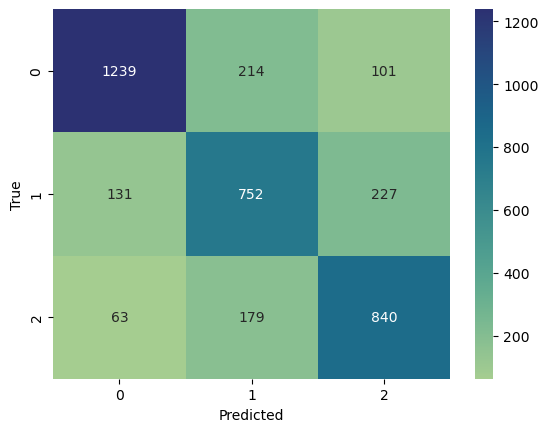

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### emotionモデル

#### emotionモデルの学習

In [29]:
label_size = df["emotion"].nunique()
embedding_size = 300
model = SimpleNN(input_size=embedding_size, hidden_size=100, num_classes=label_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
label_size

8

In [48]:
num_epochs = 50
best_f1_score = 0.0
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader_emotion:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader_emotion:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.numpy())
            val_labels.extend(labels.numpy())
    accuracy = accuracy_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds, average='weighted')

    print(f'Epoch {epoch+1}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

Epoch 1, Accuracy: 0.5749, F1 Score: 0.5022
Epoch 2, Accuracy: 0.5984, F1 Score: 0.5480
Epoch 3, Accuracy: 0.6179, F1 Score: 0.5827
Epoch 4, Accuracy: 0.6147, F1 Score: 0.5813
Epoch 5, Accuracy: 0.6262, F1 Score: 0.5879
Epoch 6, Accuracy: 0.6318, F1 Score: 0.6004
Epoch 7, Accuracy: 0.6355, F1 Score: 0.6093
Epoch 8, Accuracy: 0.6334, F1 Score: 0.6108
Epoch 9, Accuracy: 0.6401, F1 Score: 0.6217
Epoch 10, Accuracy: 0.6401, F1 Score: 0.6290
Epoch 11, Accuracy: 0.6430, F1 Score: 0.6180
Epoch 12, Accuracy: 0.6467, F1 Score: 0.6285
Epoch 13, Accuracy: 0.6433, F1 Score: 0.6216
Epoch 14, Accuracy: 0.6457, F1 Score: 0.6316
Epoch 15, Accuracy: 0.6467, F1 Score: 0.6347
Epoch 16, Accuracy: 0.6427, F1 Score: 0.6204
Epoch 17, Accuracy: 0.6534, F1 Score: 0.6390
Epoch 18, Accuracy: 0.6510, F1 Score: 0.6286
Epoch 19, Accuracy: 0.6521, F1 Score: 0.6325
Epoch 20, Accuracy: 0.6473, F1 Score: 0.6362
Epoch 21, Accuracy: 0.6438, F1 Score: 0.6315
Epoch 22, Accuracy: 0.6470, F1 Score: 0.6353
Epoch 23, Accuracy:

#### emotionモデルの検証

In [49]:
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for inputs, labels in test_loader_emotion:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.numpy())
        test_labels.extend(labels.numpy())

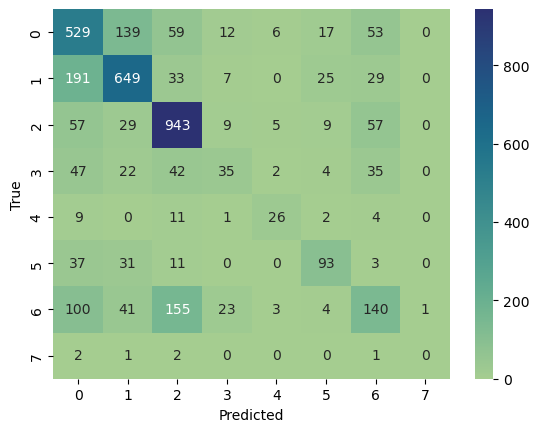

In [51]:
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()